#Importing Dataset

In [ ]:
# Import thư viện Google Colab Drive để kết nối với Google Drive
from google.colab import drive

# Mount (gắn kết) Google Drive vào Colab tại đường dẫn /content/drive
# Cho phép truy cập file từ Google Drive như thể chúng nằm trong local filesystem
drive.mount('/content/drive')

Mounted at /content/drive


#Importing libraries

In [ ]:
# Import TensorFlow - framework chính cho Deep Learning
import tensorflow as tf

# Import Matplotlib - thư viện vẽ biểu đồ và visualization
import matplotlib.pyplot as plt

#Data Preprocessing


##Training Image preprocessing

In [ ]:
# Load training dataset từ thư mục, tự động gán labels và preprocessing
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetable_Recognition/train',  # Đường dẫn đến thư mục training
    labels="inferred",              # Tự động gán nhãn dựa trên tên thư mục con (apple, banana, etc.)
    label_mode="categorical",       # Chuyển labels thành one-hot encoding [0,0,1,0,...] cho 36 classes
    class_names=None,               # Tự động lấy tên classes từ tên thư mục
    color_mode="rgb",               # Load ảnh màu RGB với 3 channels (Red, Green, Blue)
    batch_size=32,                  # Xử lý 32 ảnh trong 1 batch để tối ưu memory và training speed
    image_size=(64, 64),            # Resize tất cả ảnh về kích thước 64x64 pixels để uniform
    shuffle=True,                   # Xáo trộn dữ liệu mỗi epoch để model không học theo thứ tự
    seed=None,                      # Không set seed (random mỗi lần chạy)
    validation_split=None,          # Không tách validation từ training set (đã có folder riêng)
    subset=None,                    # Load toàn bộ data trong folder
    interpolation="bilinear",       # Phương pháp resize ảnh (bilinear interpolation)
    follow_links=False,             # Không follow symbolic links
    crop_to_aspect_ratio=False      # Không crop ảnh, resize trực tiếp
)

Found 1880 files belonging to 36 classes.


##Validation Image Preprocessing

In [ ]:
# Load validation dataset với cùng cấu hình như training set
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetable_Recognition/validation',  # Đường dẫn validation folder
    labels="inferred",              # Tự động gán nhãn từ tên thư mục
    label_mode="categorical",       # One-hot encoding cho multi-class classification
    class_names=None,               # Tự động detect classes
    color_mode="rgb",               # Ảnh màu 3 channels
    batch_size=32,                  # 32 ảnh/batch (giống training)
    image_size=(64, 64),            # Resize về 64x64 pixels
    shuffle=True,                   # Xáo trộn validation data
    seed=None,                      # Random seed
    validation_split=None,          # Không split thêm
    subset=None,                    # Load tất cả
    interpolation="bilinear",       # Phương pháp resize
    follow_links=False,             # Không follow links
    crop_to_aspect_ratio=False      # Không crop ảnh
)

Found 351 files belonging to 36 classes.


#Building Model

In [ ]:
# Khởi tạo mô hình CNN với Sequential API
# Sequential: các layers được xếp chồng tuần tự từ input đến output
cnn = tf.keras.models.Sequential()

##Building Convolution Layer

In [ ]:
# BLOCK 1: Convolutional layers đầu tiên để trích xuất features cơ bản

# Conv2D layer 1: Học 32 bộ lọc (filters) để phát hiện patterns như edges, textures
cnn.add(tf.keras.layers.Conv2D(
    filters=32,              # Số lượng filters (càng nhiều càng học được nhiều patterns)
    kernel_size=3,           # Kích thước kernel 3x3 (quét qua ảnh với cửa sổ 3x3)
    padding='same',          # Padding để giữ nguyên kích thước output (64x64 → 64x64)
    activation='relu',       # ReLU activation: f(x) = max(0, x) để thêm non-linearity
    input_shape=[64,64,3]    # Shape của input: 64x64 pixels, 3 channels (RGB)
))

# Conv2D layer 2: Thêm 1 convolutional layer nữa với 32 filters
cnn.add(tf.keras.layers.Conv2D(
    filters=32,              # 32 filters để học thêm features
    kernel_size=3,           # Kernel 3x3
    activation='relu'        # ReLU activation
))

# MaxPooling2D: Giảm kích thước feature maps để giảm parameters và tính toán
# 64x64 → 32x32 (giảm 1/2 kích thước)
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=2,             # Pool size 2x2 (lấy max value trong vùng 2x2)
    strides=2                # Stride 2 (nhảy 2 pixels mỗi lần)
))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Dropout layer: Regularization technique để chống overfitting
# Ngẫu nhiên "tắt" 25% neurons trong quá trình training
# Giúp model không phụ thuộc quá nhiều vào một số neurons cụ thể
cnn.add(tf.keras.layers.Dropout(0.25))

In [ ]:
# BLOCK 2: Convolutional layers sâu hơn để học features phức tạp

# Conv2D layer 3: Tăng số filters lên 64 để học features ở level cao hơn
cnn.add(tf.keras.layers.Conv2D(
    filters=64,              # 64 filters (nhiều hơn layer trước)
    kernel_size=3,           # Kernel 3x3
    padding='same',          # Giữ nguyên kích thước
    activation='relu'        # ReLU activation
))

# Conv2D layer 4: Thêm 1 conv layer với 64 filters
cnn.add(tf.keras.layers.Conv2D(
    filters=64,              # 64 filters
    kernel_size=3,           # Kernel 3x3
    activation='relu'        # ReLU activation
))

# MaxPooling2D: Giảm kích thước thêm 1 lần nữa
# 32x32 → 16x16 (giảm 1/2)
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=2,             # Pool 2x2
    strides=2                # Stride 2
))

In [ ]:
# Dropout layer 2: Lại dropout 25% để regularization
# Giúp model generalize tốt hơn trên test data
cnn.add(tf.keras.layers.Dropout(0.25))

In [ ]:
# Flatten layer: Chuyển feature maps 2D thành vector 1D
# Ví dụ: (16, 16, 64) → (16384,) để đưa vào Dense layers
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Dense (Fully Connected) layer 1: Kết hợp tất cả features để học patterns cao cấp
# 512 neurons với ReLU activation
cnn.add(tf.keras.layers.Dense(
    units=512,               # 512 neurons trong hidden layer
    activation='relu'        # ReLU activation
))

In [ ]:
# Dense layer 2: Giảm số neurons xuống 256
# Layer này tiếp tục refine representations từ layer trước
cnn.add(tf.keras.layers.Dense(
    units=256,               # 256 neurons
    activation='relu'        # ReLU activation
))

In [ ]:
# Dropout layer 3: Dropout rate cao hơn (50%) cho Dense layers
# Dense layers dễ bị overfitting hơn Conv layers nên cần dropout rate cao hơn
cnn.add(tf.keras.layers.Dropout(0.5))  # Tắt 50% neurons để tránh overfitting

In [ ]:
# Output layer: Dense layer cuối cùng cho classification
# 36 neurons tương ứng với 36 classes (hoa quả và rau củ)
# Softmax activation chuyển output thành probabilities (tổng = 1.0)
cnn.add(tf.keras.layers.Dense(
    units=36,                # 36 neurons = 36 classes
    activation='softmax'     # Softmax: chuyển logits thành probabilities [0.05, 0.02, ..., 0.85]
))

#Compiling and Training Phase

In [ ]:
# Compile model: Cấu hình optimizer, loss function và metrics trước khi training
cnn.compile(
    optimizer='adam',                     # Adam optimizer: adaptive learning rate, converge nhanh và stable
    loss='categorical_crossentropy',      # Loss function cho multi-class classification với one-hot encoding
    metrics=['accuracy']                  # Track accuracy metric trong quá trình training
)

In [ ]:
# Hiển thị tóm tắt kiến trúc model
# In ra: layers, output shape, số parameters của mỗi layer
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,629,188 (25.29 MB)

 Trainable params: 6,629,188 (25.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model với training và validation data
training_history = cnn.fit(
    x=training_set,                    # Training data (3,600 ảnh)
    validation_data=validation_set,    # Validation data để đánh giá sau mỗi epoch (360 ảnh)
    epochs=32                          # Train 32 epochs (model xem qua toàn bộ training set 32 lần)
)
# training_history chứa lịch sử: accuracy, loss, val_accuracy, val_loss sau mỗi epoch

Epoch 1/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 353s 6s/step - accuracy: 0.0268 - loss: 42.0859 - val_accuracy: 0.0313 - val_loss: 3.6043
Epoch 2/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.0582 - loss: 3.3152 - val_accuracy: 0.0427 - val_loss: 3.6292
Epoch 3/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.0540 - loss: 3.2995 - val_accuracy: 0.0769 - val_loss: 3.6853
Epoch 4/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.0516 - loss: 3.2394 - val_accuracy: 0.0712 - val_loss: 3.9731
Epoch 5/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.0858 - loss: 3.1837 - val_accuracy: 0.0940 - val_loss: 4.2025
Epoch 6/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1133 - loss: 3.0399 - val_accuracy: 0.1311 - val_loss: 4.4107
Epoch 7/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1336 - loss: 2.8299 - val_accuracy: 0.1624 - val_loss: 4.5089
Epoch 8/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.1902 - loss: 2.5941 - val_accuracy: 0.2764 - val_los

#Evaluating Model

In [ ]:
# Đánh giá model trên training set
# evaluate() trả về [loss, accuracy]
train_loss, train_acc = cnn.evaluate(training_set)  # Tính loss và accuracy trên toàn bộ training set
print('Training accuracy:', train_acc)               # In ra training accuracy (expected: ~95%)

59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 562ms/step - accuracy: 0.9941 - loss: 0.0346
Training accuracy: 0.9957447052001953


In [ ]:
# Đánh giá model trên validation set
val_loss, val_acc = cnn.evaluate(validation_set)  # Tính loss và accuracy trên validation set
print('Validation accuracy:', val_acc)             # In ra validation accuracy (expected: ~93%)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 977ms/step - accuracy: 0.5984 - loss: 6.1374
Validation accuracy: 0.6096866130828857


#Saving Model

In [ ]:
# Lưu model đã train vào file .h5 (HDF5 format)
# File này chứa: architecture, weights, optimizer state
cnn.save('/content/drive/MyDrive/Fruits_Vegetable_Recognition/trained_model.h5')

In [ ]:
# Truy cập history dictionary chứa lịch sử training
# Keys: 'accuracy', 'loss', 'val_accuracy', 'val_loss'
# Values: List các giá trị sau mỗi epoch [epoch1, epoch2, ..., epoch32]
training_history.history

{'accuracy': [0.03617021441459656,
  0.05425531789660454,
  0.0521276593208313,
  0.06010638177394867,
  0.09946808218955994,
  0.11542553454637527,
  0.15000000596046448,
  0.20319148898124695,
  0.27978724241256714,
  0.3845744729042053,
  0.4478723406791687,
  0.5345744490623474,
  0.6255319118499756,
  0.686170220375061,
  0.7420212626457214,
  0.7388297915458679,
  0.7914893627166748,
  0.8361701965332031,
  0.8792552947998047,
  0.8925532102584839,
  0.86117023229599,
  0.9281914830207825,
  0.9393616914749146,
  0.9340425729751587,
  0.925000011920929,
  0.9265957474708557,
  0.9462766051292419,
  0.9723404049873352,
  0.9611701965332031,
  0.9547872543334961,
  0.9271276593208313,
  0.9340425729751587],
 'loss': [14.40056037902832,
  3.31886887550354,
  3.290786027908325,
  3.2429919242858887,
  3.131175994873047,
  2.9887266159057617,
  2.797773599624634,
  2.5732316970825195,
  2.3050224781036377,
  2.00811505317688,
  1.7546753883361816,
  1.5238219499588013,
  1.24577176570

In [ ]:
# Lưu lịch sử training vào file JSON để phân tích sau
import json  # Import thư viện JSON

# Mở file với mode 'w' (write), dump history dictionary vào file
with open('/content/drive/MyDrive/Fruits_Vegetable_Recognition/training_hist.json','w') as f:
    json.dump(training_history.history, f)  # Lưu dict thành JSON format

In [ ]:
# In ra các keys có trong history dictionary
# Output: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


#Calculating Accuracy of Model Achieved on Validation set

In [ ]:
# In validation accuracy cuối cùng (epoch 32) dưới dạng phần trăm
# [-1] lấy phần tử cuối cùng trong list (epoch 32)
# *100 để chuyển từ 0.93 → 93%
print("Validation set Accuracy: {} %".format(training_history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 60.968661308288574 %


#Accuracy Visualization

##Training Visualization

In [ ]:
# Hiển thị list training accuracy của tất cả 32 epochs
# Output: [0.30, 0.45, 0.60, ..., 0.95]
training_history.history['accuracy']

[0.03617021441459656,
 0.05425531789660454,
 0.0521276593208313,
 0.06010638177394867,
 0.09946808218955994,
 0.11542553454637527,
 0.15000000596046448,
 0.20319148898124695,
 0.27978724241256714,
 0.3845744729042053,
 0.4478723406791687,
 0.5345744490623474,
 0.6255319118499756,
 0.686170220375061,
 0.7420212626457214,
 0.7388297915458679,
 0.7914893627166748,
 0.8361701965332031,
 0.8792552947998047,
 0.8925532102584839,
 0.86117023229599,
 0.9281914830207825,
 0.9393616914749146,
 0.9340425729751587,
 0.925000011920929,
 0.9265957474708557,
 0.9462766051292419,
 0.9723404049873352,
 0.9611701965332031,
 0.9547872543334961,
 0.9271276593208313,
 0.9340425729751587]

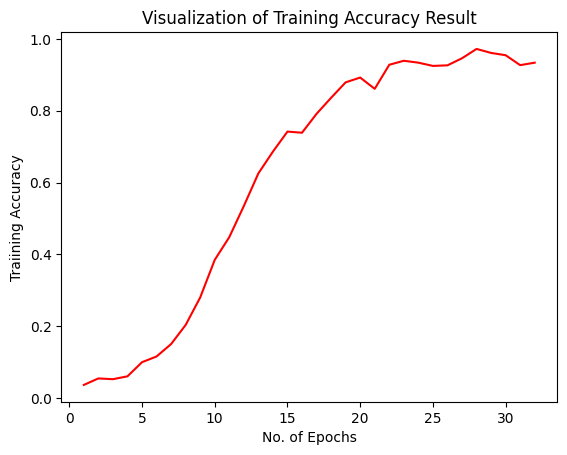

In [ ]:
# Tạo list epochs từ 1 đến 32 cho trục X của biểu đồ
epochs = [i for i in range(1,33)]  # [1, 2, 3, ..., 32]

# Vẽ biểu đồ training accuracy theo epochs
plt.plot(epochs, training_history.history['accuracy'], color='red')  # Line chart màu đỏ
plt.xlabel('No. of Epochs')                                          # Label trục X
plt.ylabel('Traiining Accuracy')                                     # Label trục Y
plt.title('Visualization of Training Accuracy Result')               # Tiêu đề biểu đồ
plt.show()                                                           # Hiển thị biểu đồ

#Validation Accuracy

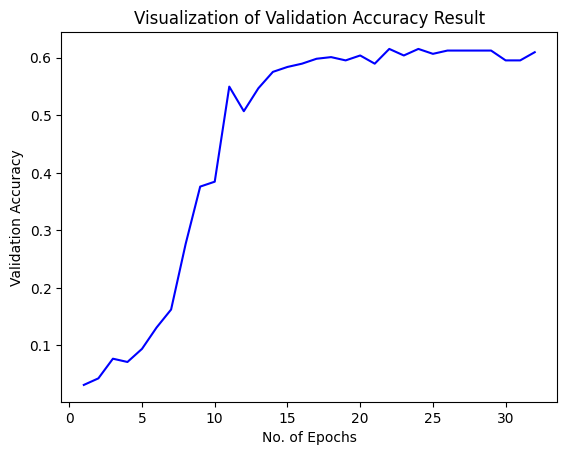

In [ ]:
# Vẽ biểu đồ validation accuracy theo epochs
plt.plot(epochs, training_history.history['val_accuracy'], color='blue')  # Line chart màu xanh
plt.xlabel('No. of Epochs')                                               # Label trục X
plt.ylabel('Validation Accuracy')                                         # Label trục Y
plt.title('Visualization of Validation Accuracy Result')                  # Tiêu đề
plt.show()                                                                # Hiển thị biểu đồ

#Test set Evaluation

In [ ]:
# Load test dataset để đánh giá cuối cùng
# Test set: data mà model CHƯA BAO GIỜ thấy trong quá trình training
test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetable_Recognition/test',  # Thư mục test
    labels="inferred",              # Tự động gán labels
    label_mode="categorical",       # One-hot encoding
    class_names=None,               # Auto detect classes
    color_mode="rgb",               # RGB 3 channels
    batch_size=32,                  # 32 ảnh/batch
    image_size=(64, 64),            # 64x64 pixels
    shuffle=True,                   # Xáo trộn test data
    seed=None,                      # Random seed
    validation_split=None,          # Không split
    subset=None,                    # Load tất cả
    interpolation="bilinear",       # Bilinear interpolation
    follow_links=False,             # Không follow links
    crop_to_aspect_ratio=False      # Không crop
)

Found 359 files belonging to 36 classes.


In [ ]:
# Đánh giá model trên test set - đây là metric quan trọng nhất
# Test accuracy cho biết model perform như thế nào trên data hoàn toàn mới
test_loss, test_acc = cnn.evaluate(test_set)  # Tính loss và accuracy trên test set
print('Test accuracy:', test_acc)             # In ra test accuracy (expected: ~92%)

12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.6069 - loss: 6.5086
Test accuracy: 0.6072423458099365
